# Package

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score

In [124]:
class Fill_method1:
    def __init__(self, data, col, label, label_type):
        self.data = data
        self.col = col
        self.label = label
        self.label_type = label_type
        self.ls_impo_top10 = None
        self.ls_impo_combine = None
        self.df = None
        self.y_drop, self.y_ndrop = None, None
        self.x_idx, self.x_nidx = None, None
        
    def preprocessing(self):
        self.df = self.data.drop([self.label], axis = 1)
        self.y_drop = self.df[self.col].dropna(axis = 0)
        self.y_ndrop = self.df[self.col]
        x = self.df.dropna(axis = 1)
        x2 = x.loc[self.y_drop.index]
        x2 = pd.get_dummies(x2, drop_first=True)
        x3 = pd.get_dummies(x, drop_first=True)
        self.x_idx = x2
        self.x_nidx = x3
        
    def impo_measure_top10(self):
        X_train, X_test, y_train, y_test = train_test_split(self.x_idx, self.y_drop, test_size = 0.2, random_state = 111)
        if self.label_type == object:
            model = ExtraTreesClassifier(random_state=111)
        else:
            model = ExtraTreesRegressor(random_state=111) 
        model.fit(X_train, y_train)
        self.ls_impo_top10 = list(zip(X_train.columns, model.feature_importances_))
        self.ls_impo_top10.sort(reverse=True, key=lambda x: x[1])
        return self.ls_impo_top10
    
    def impo_measure_combine(self):
        ls_impo, ls_score, ls_model = [], [], []
        for i in range(0, 10):
            ls_feature_10 = np.array(self.ls_impo_top10)[:, 0]
            col_feature = ls_feature_10[0: i + 1]
            x = self.x_idx[col_feature]
            X_train, X_test, y_train, y_test = train_test_split(x, self.y_drop, test_size = 0.2, random_state = 111)
            if self.label_type == object:
                model = ExtraTreesClassifier(random_state=111)
            else:
                model = ExtraTreesRegressor(random_state=111) 
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)
            if self.label_type == object:
                score = f1_score(y_test, y_test_pred)
            else:
                score = r2_score(y_test, y_test_pred)
            ls_impo.append(col_feature)
            ls_score.append(score)
            ls_model.append(model)
        self.ls_impo_combine = list(zip(ls_impo, ls_score, ls_model))
        self.ls_impo_combine.sort(reverse=True, key=lambda x: x[1])
        return self.ls_impo_combine
    
    def fillna(self):
        x = self.x_nidx[self.ls_impo_combine[0][0]].loc[pd.isnull(self.y_ndrop) == True]
        self.data[self.col].loc[pd.isnull(self.y_ndrop) == True] = self.ls_impo_combine[0][2].predict(x)
        return self.data

# 1. Data

In [125]:
file_path = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\train.csv'
data = pd.read_csv(file_path, encoding="Big5", low_memory=False)
data.drop('Id',axis=1, inplace = True)

In [126]:
data_copy = data.copy()

In [127]:
data.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


# 2. Type Convertion

* 將順序型類別型態特徵按其程度順序依序賦予1、2、3、4...。例如特徵「ExterQual 外部材料品質」，該特徵的類別分別為Excellent、Good、Average/Typical、Fair、Poor，這些類別的意涵本身具有順序性，因此按其意涵的順序分別賦予5、4、3、2、1。
* 有些特徵的欄位中出現遺漏值，但在意涵上並非遺漏值而是「不具該特徵」的類別，例如特徵「BsmtQual 地下室之高度」，其中的遺漏值是指「沒有地下室」，也屬於該特徵其中一項類別。對於這類特徵的遺漏值會將其賦予一個新的類別'NA'。
* 對於順序型類別型態特徵且具有'NA'類別的特徵，在做數值轉換時會將'NA'賦予一個極端的數值999，並會新增一項欄位「是否具有該特徵」，有的話為0，沒有則為1。
* 將意涵上為類別型態的數值形態特徵轉換為類別型態。

In [128]:
types = data.dtypes
types.unique()
obj = types.loc[types == object]
num = types.loc[types != object]

In [129]:
obj

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

In [130]:
num

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [131]:
data['LotShape'] = data['LotShape'].map({'IR1': 1, 'IR2': 2, 'IR3': 3, 'Reg': 4})
data['Utilities'] = data['Utilities'].map({'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4})
data['LandSlope'] = data['LandSlope'].map({'Gtl': 1, 'Mod': 2, 'Sev': 3})
data['ExterQual'] = data['ExterQual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
data['ExterCond'] = data['ExterCond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1' 均和地下室有關且在data description文件中都有紀載具有「沒有地下室」這個類別，然而這些特徵在資料中都沒有出現「沒有地下室」這個類別，只有遺漏值。發現這些遺漏值在這些特徵中都剛好在同一列上，因此推論這些遺漏值應該就是「沒有地下室」這個類別。

In [132]:
dict_bst_obj = {}
ls_bst_obj = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1']
for i in ls_bst_obj:
    ls = []
    ls.append(sum(pd.isnull(data[i])))
    sry_nan = pd.isnull(data[i])
    ls.append(sry_nan.loc[sry_nan == True].index.values)
    dict_bst_obj[i] = ls
dict_bst_obj

{'BsmtQual': [37,
  array([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
          520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
          897,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179, 1216,
         1218, 1232, 1321, 1412], dtype=int64)],
 'BsmtCond': [37,
  array([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
          520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
          897,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179, 1216,
         1218, 1232, 1321, 1412], dtype=int64)],
 'BsmtExposure': [38,
  array([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
          520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
          897,  948,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179,
         1216, 1218, 1232, 1321, 1412], dtype=int64)],
 'BsmtFinType2': [38,
  array([  17,   39,   90,  102,  156,  182,  259,  332,  342,  362,  371,
          392,  5

In [133]:
data['BsmtQual'].fillna('No', inplace = True)
data['BsmtQual'] = data['BsmtQual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No': 999})
data['NoBsmt'] = np.zeros(data.shape[0])
data.loc[data['BsmtQual'] == 999, 'NoBsmt'] = 1
data['BsmtCond'].fillna('No', inplace = True)
data['BsmtCond'] = data['BsmtCond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No': 999})
data.loc[data['NoBsmt'] == 1, 'BsmtExposure'] = 'No' 
data['BsmtExposure'] = data['BsmtExposure'].map({'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4, 'No': 999})
data.loc[data['NoBsmt'] == 1, 'BsmtFinType2'] = 'No' 
data['BsmtFinType2'] = data['BsmtFinType2'].map({'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 
                                                 'ALQ': 5, 'GLQ':6, 'No': 999})
data['BsmtFinType1'].fillna('No', inplace = True)
data['BsmtFinType1'] = data['BsmtFinType1'].map({'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 
                                                 'ALQ': 5, 'GLQ':6, 'No': 999})

'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'這些是與地下室有關的數值型態變數，可以發現當「是否具有地下室」這個特徵中「沒有地下室」的類別對應到這些特徵的數值均為0，因此更可以肯定'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1' 這些類別型態特徵的遺漏值為「沒有地下室」這個類別。

In [134]:
dict_bst_num = {}
ls_bst_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for i in ls_bst_num:
    ls = []
    ls.append(sum(pd.isnull(data[i])))
    ls.append(data.loc[data['NoBsmt'] == 1, i].unique())
    dict_bst_num[i] = ls
dict_bst_num

{'BsmtFinSF1': [0, array([0], dtype=int64)],
 'BsmtFinSF2': [0, array([0], dtype=int64)],
 'BsmtUnfSF': [0, array([0], dtype=int64)],
 'TotalBsmtSF': [0, array([0], dtype=int64)],
 'BsmtFullBath': [0, array([0], dtype=int64)],
 'BsmtHalfBath': [0, array([0], dtype=int64)]}

In [135]:
data['HeatingQC'] = data['HeatingQC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
data['CentralAir'] = data['CentralAir'].map({'N': 0, 'Y': 1})
data['KitchenQual'] = data['KitchenQual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
data['Functional'] = data['Functional'].map({'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5,
                                             'Min2': 6, 'Min1': 7, 'Typ': 8})
data['FireplaceQu'] = data['FireplaceQu'].map({'TA': 1, 'Gd': 2, 'Ex': 3})

'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt'這些特徵的遺漏值判斷方式與地下室相同。

In [136]:
dict_grg_obj = {}
ls_grg_obj = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt']
for i in ls_grg_obj:
    ls = []
    ls.append(sum(pd.isnull(data[i])))
    sry_nan = pd.isnull(data[i])
    ls.append(sry_nan.loc[sry_nan == True].index.values)
    dict_grg_obj[i] = ls

In [137]:
data['GarageType'].fillna('No', inplace = True)
data['NoGrg'] = np.zeros(data.shape[0])
data.loc[data['GarageType'] == 'No', 'NoGrg'] = 1
data['GarageFinish'].fillna('No', inplace = True)
data['GarageFinish'] = data['GarageFinish'].map({'Unf': 1, 'RFn': 2, 'Fin': 3, 'No': 999})
data['GarageQual'].fillna('No', inplace = True)
data['GarageQual'] = data['GarageQual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No': 999})
data['GarageCond'].fillna('No', inplace = True)
data['GarageCond'] = data['GarageCond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No': 999})

In [138]:
dict_grg_num = {}
ls_grg_num = ['GarageCars', 'GarageArea']
for i in ls_grg_num:
    ls = []
    ls.append(sum(pd.isnull(data[i])))
    ls.append(data.loc[data['NoGrg'] == 1, i].unique())
    dict_grg_num[i] = ls

判定'GarageYrBlt'的遺漏值是因為沒有Garage而產生，因此將遺漏值賦予0。  
'GarageYrBlt'是意涵上為類別型態的數值形態特徵，因此將其轉換成類別型態。  
由於'GarageYrBlt'的類別過多，期望能減少類別數量。從'GarageYrBlt', 'SalePrice'(預測的目標變數)的關係圖中判定在1980年後'SalePrice'整體平均上升，因此將'GarageYrBlt'切成三種類別「>=1980」、「<1980」、「沒有garage」。

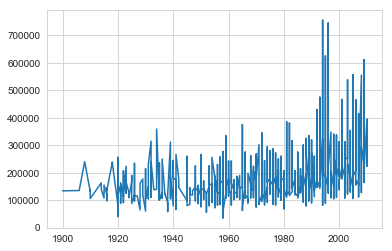

In [139]:
df = data[['GarageYrBlt', 'SalePrice']]
df = df.loc[pd.isnull(df['GarageYrBlt']) != True]
df.sort_values(by = 'GarageYrBlt', ascending = True, inplace = True)
x = df['GarageYrBlt']
y = df['SalePrice']
plt.plot(x, y)

In [140]:
data['GarageYrBlt'].fillna(0, inplace = True)
data['GrgYrBltPrd'] = 0
data.loc[data['GarageYrBlt'] >= 1980, 'GrgYrBltPrd'] = '>= 1980'
data.loc[(data['GarageYrBlt'] < 1980) & (data['GarageYrBlt'] > 0), 'GrgYrBltPrd'] = '< 1980'
data.loc[data['GarageYrBlt'] == 0, 'GrgYrBltPrd'] = 'No'
data.drop(['GarageYrBlt'], axis = 1, inplace = True)

In [141]:
data['PavedDrive'] = data['PavedDrive'].map({'N': 1, 'P': 2, 'Y': 3})
data['PoolQC'].fillna('No', inplace = True)
data['NoPool'] = 0
data.loc[data['PoolQC'] == 'No', 'NoPool'] = 1
data['PoolQC'] = data['PoolQC'].map({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4, 'No': 999})

data['Fence'].fillna('No', inplace = True)
data['NoFence'] = 0
data.loc[data['Fence'] == 'No', 'NoFence'] = 1
data['Fence'] = data['Fence'].map({'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4, 'No': 999})

data['MiscFeature'].fillna('No', inplace = True)

YearRemodAdd得切割概念與GarageYrBlt相同

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


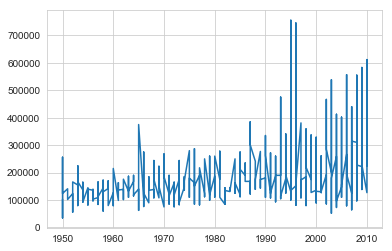

In [142]:
data['YearRemodAdd'].unique()
df = data[['YearRemodAdd', 'SalePrice']]
df.sort_values(by = 'YearRemodAdd', ascending = True, inplace = True)
x = df['YearRemodAdd']
y = df['SalePrice']
plt.plot(x, y)

In [143]:
data['YearRemodAdd_Prd'] = 0
data.loc[data['YearRemodAdd'] >= 1990, 'YearRemodAdd_Prd'] = '>= 1990'
data.loc[data['YearRemodAdd'] < 1990, 'YearRemodAdd_Prd'] = '< 1990'
data.drop(['YearRemodAdd'], axis = 1, inplace = True)

將QSold十二個類別轉換成季，共四個類別。

In [144]:
data['QSold'] = 'Q1'
data.loc[(data['MoSold'] <=6) & (data['MoSold'] >= 4), 'QSold'] = 'Q2'
data.loc[(data['MoSold'] <=9) & (data['MoSold'] >= 7), 'QSold'] = 'Q3'
data.loc[(data['MoSold'] <=12) & (data['MoSold'] >= 10), 'QSold'] = 'Q4'
data.drop(['MoSold'], axis = 1, inplace = True)

In [145]:
data['YrSold'] = data['YrSold'].astype('object')

In [146]:
data['Alley'].fillna('No', inplace = True)

In [147]:
data['FireplaceQu'].fillna(999, inplace = True)
data['NoFireplace'] = 0
data.loc[data['FireplaceQu'] == 999, 'NoFireplace'] = 1

In [148]:
data['MasVnrType'].fillna('No', inplace = True)
data['MasVnrArea'].fillna(0, inplace = True)

將剩餘的類別型態變數整理起來。

In [149]:
types = data.dtypes
obj = types.loc[types == object]
obj

MSZoning            object
Street              object
Alley               object
LandContour         object
LotConfig           object
Neighborhood        object
Condition1          object
Condition2          object
BldgType            object
HouseStyle          object
RoofStyle           object
RoofMatl            object
Exterior1st         object
Exterior2nd         object
MasVnrType          object
Foundation          object
Heating             object
Electrical          object
GarageType          object
MiscFeature         object
YrSold              object
SaleType            object
SaleCondition       object
GrgYrBltPrd         object
YearRemodAdd_Prd    object
QSold               object
dtype: object

# 3. 遺漏值填補

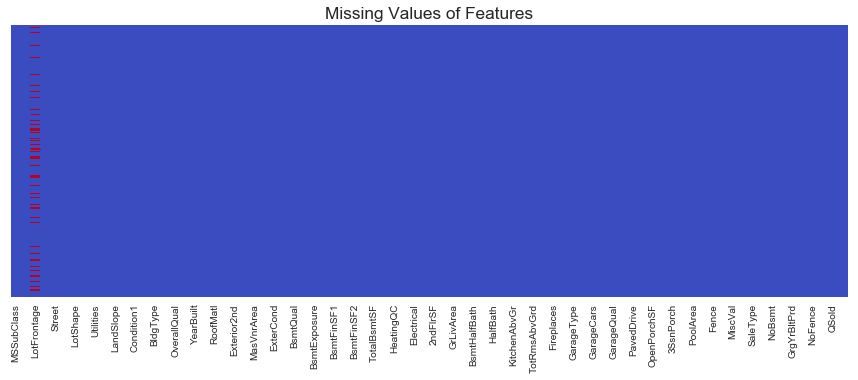

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=[15, 5])
plt.title("Missing Values of Features", fontdict={"fontsize":"xx-large"})
sns.heatmap(data.drop("SalePrice", axis=1).isnull(), yticklabels=False, cbar=False, cmap="coolwarm")

In [151]:
nan_col = pd.DataFrame(pd.isnull(data).sum(), columns = ['num'])
nan_col = nan_col.loc[nan_col['num'] != 0]
nan_col['percentage'] = nan_col['num'] / data.shape[0]
nan_col.sort_values(by = 'num', ascending = False, inplace = True)
nan_col

,num,percentage
LotFrontage,259,0.177397
BsmtExposure,1,0.000685
BsmtFinType2,1,0.000685
Electrical,1,0.000685


In [152]:
def count_null(cols):
    null_count = sum(pd.isnull(cols))
    return null_count


nan_row = data.apply(count_null, axis=1)
nan_row_index = data.loc[nan_row > (data.shape[1] // 2)].index
nan_row.unique()

array([0, 1], dtype=int64)

BsmtExposure、BsmtFinType2為地下室有關的特徵，該特徵的遺漏值基本上都對應到「沒有地下室」的類別，唯獨有一列沒有，將其視為誤差，直接以該特徵欄位的眾數來填補。

In [153]:
from statistics import mode


m = mode(data.loc[data['BsmtExposure'] != 999, 'BsmtExposure'])
data['BsmtExposure'].fillna(m, inplace = True)

m = mode(data.loc[data['BsmtFinType2'] != 999, 'BsmtFinType2'])
data['BsmtFinType2'].fillna(m, inplace = True)

將資料集中沒有缺失值的欄位作為解釋變數，將欲填補的欄位作
為被解釋變數， 利用 ExtraTreesRegressor模型中
feature importances 功能，計算出每個解釋變數 對於被解釋變數欄
位 的重要性分數，並依序排序， 找出前 10 重要的欄位 解釋變數
再 將該 10 個欄位分成 : 第一重要欄位、第一 + 第二重要欄位、第一 + 第二 + 第三重要欄位 共 10 組欄位組合， 依序用這 10 組特徵
組合作為解釋變數，欲填補的欄位做為被解釋變數， 用
ExtraTreesRegressor模型進行運算，每組特徵運算時都會有一個正
確率指標作為對應。 若 欲填補的欄位是類別型態變數，正確率指標為
F1 score；若 欲填補的欄位是數值型態變數，正確率指標為 MSE和
RMSE。 最後取正確率指標最好的特徵組合，用 ExtraTreesRegressor模型，來預測與填補欲填補的欄位的缺失值。

In [154]:
col = 'LotFrontage'
label = 'SalePrice'
#label_type = data[label].dtypes 
F = Fill_method1(data, col, label, float)            
F.preprocessing()     
k = F.impo_measure_top10()   
k2 = F.impo_measure_combine()
data = F.fillna()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: Future

In [155]:
print('Feature Importance')
for i in range(len(k)):
    print(k[i][0], ': ', k[i][1])

Feature Importance
LotArea :  0.12836628084927693
MSZoning_RL :  0.11084840779207221
MSSubClass :  0.06301686512020795
1stFlrSF :  0.03587067217925511
BsmtFinSF1 :  0.03309114986425653
Condition1_PosA :  0.03275238042734653
TotalBsmtSF :  0.032125609669963764
BldgType_TwnhsE :  0.028529811527523867
GrLivArea :  0.0277155854288778
LotConfig_CulDSac :  0.027132378962469138
LotConfig_Inside :  0.019229218295336505
BldgType_Twnhs :  0.0190729704982536
TotRmsAbvGrd :  0.017810811022669473
PoolQC :  0.016304631589728634
GarageType_Detchd :  0.015989079118328735
RoofMatl_Tar&Grv :  0.014445482770755923
GarageArea :  0.012278282356894474
Exterior2nd_Wd Sdng :  0.011021907914346285
LotShape :  0.010654150706997795
GarageCars :  0.010476816000883824
LandContour_HLS :  0.00931129223046034
Neighborhood_NridgHt :  0.00930315876879985
BldgType_2fmCon :  0.009207405856937523
LandContour_Lvl :  0.009117321346918277
YrSold_2008 :  0.008851860465267303
GarageType_Attchd :  0.008540686394260463
Neighborh

In [156]:
print('Feature Importance (combined)')
for i in range(len(k2)):
    print(k2[i][0], ': ', k2[i][1])

Feature Importance (combined)
['LotArea' 'MSZoning_RL' 'MSSubClass' '1stFlrSF' 'BsmtFinSF1'] :  0.3926245043997001
['LotArea' 'MSZoning_RL' 'MSSubClass' '1stFlrSF' 'BsmtFinSF1'
 'Condition1_PosA' 'TotalBsmtSF' 'BldgType_TwnhsE' 'GrLivArea'
 'LotConfig_CulDSac'] :  0.38880639030076225
['LotArea' 'MSZoning_RL' 'MSSubClass' '1stFlrSF' 'BsmtFinSF1'
 'Condition1_PosA' 'TotalBsmtSF' 'BldgType_TwnhsE'] :  0.37085279791367987
['LotArea' 'MSZoning_RL' 'MSSubClass' '1stFlrSF' 'BsmtFinSF1'
 'Condition1_PosA'] :  0.3267986807451304
['LotArea' 'MSZoning_RL' 'MSSubClass' '1stFlrSF' 'BsmtFinSF1'
 'Condition1_PosA' 'TotalBsmtSF' 'BldgType_TwnhsE' 'GrLivArea'] :  0.2913550770232871
['LotArea' 'MSZoning_RL' 'MSSubClass' '1stFlrSF' 'BsmtFinSF1'
 'Condition1_PosA' 'TotalBsmtSF'] :  0.2856602572562531
['LotArea' 'MSZoning_RL' 'MSSubClass' '1stFlrSF'] :  0.2759123768523525
['LotArea' 'MSZoning_RL' 'MSSubClass'] :  0.24219862025674987
['LotArea' 'MSZoning_RL'] :  0.20013033593030904
['LotArea'] :  0.18584800

In [157]:
from sklearn.preprocessing import LabelEncoder
col = 'Electrical'
sry = pd.Series(LabelEncoder().fit_transform(data.loc[data[col].notnull(), col]))
data.loc[data[col].notnull(), col] = sry.values
F = Fill_method1(data, col, label, float)            
F.preprocessing()     
k = F.impo_measure_top10()   
k2 = F.impo_measure_combine()
data = F.fillna()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: Future

In [158]:
print('Feature Importance')
for i in range(len(k)):
    print(k[i][0], ': ', k[i][1])

Feature Importance
CentralAir :  0.07309918869199017
YearBuilt :  0.06743705680083026
OverallCond :  0.02433550252469025
RoofStyle_Hip :  0.024288945770719977
Neighborhood_IDOTRR :  0.022208792587333222
Exterior1st_BrkFace :  0.021843221902302527
BsmtUnfSF :  0.020865348937987926
BedroomAbvGr :  0.018411120337672005
GarageCars :  0.01836777211182979
RoofStyle_Gable :  0.017707607116953634
1stFlrSF :  0.01703184222058667
PavedDrive :  0.016251983776005275
BsmtFinSF1 :  0.015529844693741041
QSold_Q4 :  0.014362820924812355
EnclosedPorch :  0.014222370854144064
FullBath :  0.014045035857988617
LowQualFinSF :  0.013698571701648652
KitchenQual :  0.013512045164938752
Neighborhood_NAmes :  0.013266690256964272
GarageType_Basment :  0.013011969852504274
TotRmsAbvGrd :  0.012625139272996697
GrLivArea :  0.012333316716176594
LandContour_HLS :  0.011744402989832169
GarageArea :  0.01167512123532984
Functional :  0.011373005649953425
MSSubClass :  0.010884251473991852
YrSold_2007 :  0.01075044706

In [159]:
print('Feature Importance (combined)')
for i in range(len(k2)):
    print(k2[i][0], ': ', k2[i][1])

Feature Importance (combined)
['CentralAir' 'YearBuilt'] :  0.227111983152259
['CentralAir' 'YearBuilt' 'OverallCond'] :  0.2030468194248254
['CentralAir' 'YearBuilt' 'OverallCond' 'RoofStyle_Hip'] :  0.1936914294207437
['CentralAir'] :  0.13034687559214952
['CentralAir' 'YearBuilt' 'OverallCond' 'RoofStyle_Hip'
 'Neighborhood_IDOTRR'] :  0.13008460682276046
['CentralAir' 'YearBuilt' 'OverallCond' 'RoofStyle_Hip'
 'Neighborhood_IDOTRR' 'Exterior1st_BrkFace' 'BsmtUnfSF'] :  0.09381924302646183
['CentralAir' 'YearBuilt' 'OverallCond' 'RoofStyle_Hip'
 'Neighborhood_IDOTRR' 'Exterior1st_BrkFace'] :  0.05517453568410102
['CentralAir' 'YearBuilt' 'OverallCond' 'RoofStyle_Hip'
 'Neighborhood_IDOTRR' 'Exterior1st_BrkFace' 'BsmtUnfSF' 'BedroomAbvGr'
 'GarageCars' 'RoofStyle_Gable'] :  0.0364690084864111
['CentralAir' 'YearBuilt' 'OverallCond' 'RoofStyle_Hip'
 'Neighborhood_IDOTRR' 'Exterior1st_BrkFace' 'BsmtUnfSF' 'BedroomAbvGr'] :  -0.006530597629534007
['CentralAir' 'YearBuilt' 'OverallCond' 

In [160]:
nan_col = pd.DataFrame(pd.isnull(data).sum(), columns = ['num'])
nan_col = nan_col.loc[nan_col['num'] != 0]
nan_col['percentage'] = nan_col['num'] / data.shape[0]
nan_col.sort_values(by = 'num', ascending = False, inplace = True)
nan_col

,num,percentage


# Save Data

In [161]:
file_path = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\train_cleaning.csv'
data.to_csv(file_path)